In [1]:
import os.path as osp
import os
import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, PNAConv, global_add_pool
from torch_geometric.utils import degree

In [16]:
from torch_geometric.datasets import KarateClub

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [75]:

from typing import Any, Callable, Dict, List, Optional, Union
import torch
from torch import Tensor
from torch.nn import ModuleList, Sequential
from torch.utils.data import DataLoader

from torch_geometric.nn.aggr import DegreeScalerAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import reset
from torch_geometric.nn.resolver import activation_resolver
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import degree

#### Karate data

Node Degree
   0     16
   1      9
   2     10
   3      6
   4      3
   5      4
   6      4
   7      4
   8      5
   9      2
  10      3
  11      1
  12      2
  13      5
  14      2
  15      2
  16      2
  17      2
  18      2
  19      3
  20      2
  21      2
  22      2
  23      5
  24      3
  25      3
  26      2
  27      4
  28      3
  29      4
  30      4
  31      6
  32     12
  33     17


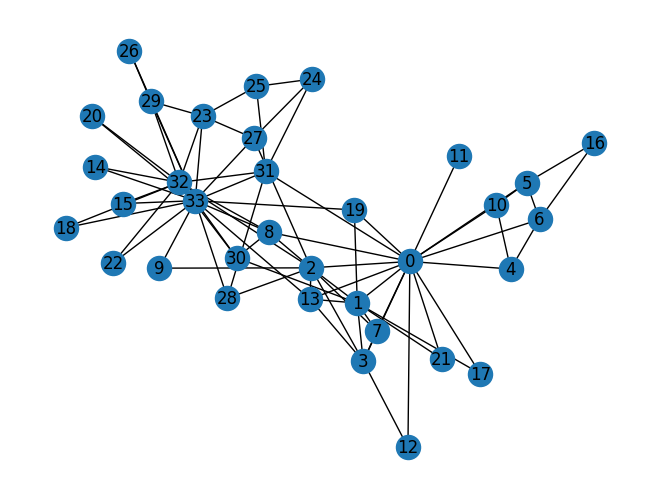

In [3]:
G = nx.karate_club_graph()
print("Node Degree")
for v in G:
    print(f"{v:4} {G.degree(v):6}")

nx.draw(G, with_labels=True)
plt.show()

In [4]:
type(G)

networkx.classes.graph.Graph

In [17]:
karate = KarateClub()

In [25]:
print(karate.num_classes)
print(karate.num_node_features)
print(karate.num_edge_features)

4
34
0


In [77]:
karate[0].x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [27]:
karate._data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [28]:
karate._data.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

In [31]:
karate._data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

#### Zinc Data

In [49]:
# get data
path = os.getcwd()+"/zinc"
train_dataset = ZINC(path, subset=True, split='train')
val_dataset = ZINC(path, subset=True, split='val')
test_dataset = ZINC(path, subset=True, split='test')


In [50]:
# put data into loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [51]:
len(train_dataset), len(val_dataset), len(test_dataset)

(10000, 1000, 1000)

In [52]:
# each index in dataset is a graph
test_dataset[2].x

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [2],
        [4],
        [0],
        [2],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2]])

In [53]:
max(test_dataset[0].x).item()

6

In [54]:
test_dataset[0].y

tensor([1.9973])

In [55]:
test_dataset[0].edge_index

tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,  7,
          8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 14, 14, 15, 15],
        [ 1,  0,  2, 15,  1,  3,  2,  4,  3,  5, 14,  4,  6,  5,  7,  6,  8, 12,
          7,  9,  8, 10,  9, 11, 10, 12,  7, 11, 13, 12,  4, 15,  1, 14]])

In [56]:
num_nodes_max = 0
for i in range(len(train_dataset)):
    temp = max(train_dataset[i].x).item()
    if num_nodes_max < temp:
        num_nodes_max = temp
num_nodes_max

20

In [57]:
test_dataset[999].edge_index, test_dataset[999].num_nodes

(tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  7,  7,
           8,  8,  8,  9,  9, 10, 10, 11, 11, 11, 11, 12, 13, 14, 15, 15, 16, 16,
          16, 16, 17, 18, 19, 19, 19, 20],
         [ 1,  0,  2, 19,  1,  3,  2,  4,  3,  5, 16,  4,  6, 15,  5,  7,  6,  8,
           7,  9, 15,  8, 10,  9, 11, 10, 12, 13, 14, 11, 11, 11,  5,  8,  4, 17,
          18, 19, 16, 16,  1, 16, 20, 19]]),
 21)

In [58]:
# Compute the maximum in-degree in the training data.
max_degree = -1
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

In [59]:
# max node connections
max_degree

4

In [60]:
# Compute the in-degree histogram tensor
deg = torch.zeros(max_degree + 1, dtype=torch.long)
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

In [61]:
# count for each number of  connections
deg

tensor([     0,  41130, 117278,  70152,   3104])

#### PNA Conv

In [76]:
class PNAConv(MessagePassing):
    r"""The Principal Neighbourhood Aggregation graph convolution operator
    from the `"Principal Neighbourhood Aggregation for Graph Nets"
    <https://arxiv.org/abs/2004.05718>`_ paper

    .. math::
        \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left(
        \mathbf{x}_i, \underset{j \in \mathcal{N}(i)}{\bigoplus}
        h_{\mathbf{\Theta}} \left( \mathbf{x}_i, \mathbf{x}_j \right)
        \right)

    with

    .. math::
        \bigoplus = \underbrace{\begin{bmatrix}
            1 \\
            S(\mathbf{D}, \alpha=1) \\
            S(\mathbf{D}, \alpha=-1)
        \end{bmatrix} }_{\text{scalers}}
        \otimes \underbrace{\begin{bmatrix}
            \mu \\
            \sigma \\
            \max \\
            \min
        \end{bmatrix}}_{\text{aggregators}},

    where :math:`\gamma_{\mathbf{\Theta}}` and :math:`h_{\mathbf{\Theta}}`
    denote MLPs.

    .. note::

        For an example of using :obj:`PNAConv`, see `examples/pna.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/
        examples/pna.py>`_.

    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        aggregators (List[str]): Set of aggregation function identifiers,
            namely :obj:`"sum"`, :obj:`"mean"`, :obj:`"min"`, :obj:`"max"`,
            :obj:`"var"` and :obj:`"std"`.
        scalers (List[str]): Set of scaling function identifiers, namely
            :obj:`"identity"`, :obj:`"amplification"`,
            :obj:`"attenuation"`, :obj:`"linear"` and
            :obj:`"inverse_linear"`.
        deg (torch.Tensor): Histogram of in-degrees of nodes in the training
            set, used by scalers to normalize.
        edge_dim (int, optional): Edge feature dimensionality (in case
            there are any). (default :obj:`None`)
        towers (int, optional): Number of towers (default: :obj:`1`).
        pre_layers (int, optional): Number of transformation layers before
            aggregation (default: :obj:`1`).
        post_layers (int, optional): Number of transformation layers after
            aggregation (default: :obj:`1`).
        divide_input (bool, optional): Whether the input features should
            be split between towers or not (default: :obj:`False`).
        act (str or callable, optional): Pre- and post-layer activation
            function to use. (default: :obj:`"relu"`)
        act_kwargs (Dict[str, Any], optional): Arguments passed to the
            respective activation function defined by :obj:`act`.
            (default: :obj:`None`)
        train_norm (bool, optional): Whether normalization parameters
            are trainable. (default: :obj:`False`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})`,
          edge indices :math:`(2, |\mathcal{E}|)`,
          edge features :math:`(|\mathcal{E}|, D)` *(optional)*
        - **output:** node features :math:`(|\mathcal{V}|, F_{out})`
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        aggregators: List[str],
        scalers: List[str],
        deg: Tensor,
        edge_dim: Optional[int] = None,
        towers: int = 1,
        pre_layers: int = 1,
        post_layers: int = 1,
        divide_input: bool = False,
        act: Union[str, Callable, None] = "relu",
        act_kwargs: Optional[Dict[str, Any]] = None,
        train_norm: bool = False,
        **kwargs,
    ):
        # Replace with LCM
        aggr = DegreeScalerAggregation(aggregators, scalers, deg, train_norm)

        ####
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if divide_input:
            assert in_channels % towers == 0
        assert out_channels % towers == 0

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.towers = towers
        self.divide_input = divide_input

        self.F_in = in_channels // towers if divide_input else in_channels
        self.F_out = self.out_channels // towers

        if self.edge_dim is not None:
            self.edge_encoder = Linear(edge_dim, self.F_in)

        self.pre_nns = ModuleList()
        self.post_nns = ModuleList()
        for _ in range(towers):
            modules = [Linear((3 if edge_dim else 2) * self.F_in, self.F_in)]
            for _ in range(pre_layers - 1):
                modules += [activation_resolver(act, **(act_kwargs or {}))]
                modules += [Linear(self.F_in, self.F_in)]
            self.pre_nns.append(Sequential(*modules))

            in_channels = (len(aggregators) * len(scalers) + 1) * self.F_in
            modules = [Linear(in_channels, self.F_out)]
            for _ in range(post_layers - 1):
                modules += [activation_resolver(act, **(act_kwargs or {}))]
                modules += [Linear(self.F_out, self.F_out)]
            self.post_nns.append(Sequential(*modules))

        self.lin = Linear(out_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        if self.edge_dim is not None:
            self.edge_encoder.reset_parameters()
        for nn in self.pre_nns:
            reset(nn)
        for nn in self.post_nns:
            reset(nn)
        self.lin.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj,
                edge_attr: OptTensor = None) -> Tensor:

        if self.divide_input:
            x = x.view(-1, self.towers, self.F_in)
        else:
            x = x.view(-1, 1, self.F_in).repeat(1, self.towers, 1)

        # propagate_type: (x: Tensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=None)

        out = torch.cat([x, out], dim=-1)
        outs = [nn(out[:, i]) for i, nn in enumerate(self.post_nns)]
        out = torch.cat(outs, dim=1)

        return self.lin(out)

    def message(self, x_i: Tensor, x_j: Tensor,
                edge_attr: OptTensor) -> Tensor:

        h: Tensor = x_i  # Dummy.
        if edge_attr is not None:
            edge_attr = self.edge_encoder(edge_attr)
            edge_attr = edge_attr.view(-1, 1, self.F_in)
            edge_attr = edge_attr.repeat(1, self.towers, 1)
            h = torch.cat([x_i, x_j, edge_attr], dim=-1)
        else:
            h = torch.cat([x_i, x_j], dim=-1)

        hs = [nn(h[:, i]) for i, nn in enumerate(self.pre_nns)]
        return torch.stack(hs, dim=1)

    def __repr__(self):
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, towers={self.towers}, '
                f'edge_dim={self.edge_dim})')

    @staticmethod
    def get_degree_histogram(loader: DataLoader) -> Tensor:
        r"""Returns the degree histogram to be used as input for the :obj:`deg`
        argument in :class:`PNAConv`."""
        deg_histogram = torch.zeros(1, dtype=torch.long)
        for data in loader:
            deg = degree(data.edge_index[1], num_nodes=data.num_nodes,
                         dtype=torch.long)
            deg_bincount = torch.bincount(deg, minlength=deg_histogram.numel())
            deg_histogram = deg_histogram.to(deg_bincount.device)
            if deg_bincount.numel() > deg_histogram.numel():
                deg_bincount[:deg_histogram.size(0)] += deg_histogram
                deg_histogram = deg_bincount
            else:
                assert deg_bincount.numel() == deg_histogram.numel()
                deg_histogram += deg_bincount

        return deg_histogram

#### Model

In [62]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.node_emb = Embedding(21, 75)
        self.edge_emb = Embedding(4, 50)

        aggregators = ['mean', 'min', 'max', 'std']
        scalers = ['identity', 'amplification', 'attenuation']

        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        for _ in range(4):
            conv = PNAConv(in_channels=75, out_channels=75,
                           aggregators=aggregators, scalers=scalers, deg=deg,
                           edge_dim=50, towers=4, pre_layers=1, post_layers=1,
                           divide_input=False)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(75))

        self.mlp = Sequential(Linear(75, 50), ReLU(), Linear(50, 25), ReLU(),
                              Linear(25, 1))

    def forward(self, x, edge_index, edge_attr, batch):
        #(n,75) tensor
        x = self.node_emb(x.squeeze())
        # (e,50) tensor
        edge_attr = self.edge_emb(edge_attr)

        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = F.relu(batch_norm(conv(x, edge_index, edge_attr)))

        x = global_add_pool(x, batch)
        return self.mlp(x)

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,
                              min_lr=0.00001)

In [64]:
model

Net(
  (node_emb): Embedding(21, 75)
  (edge_emb): Embedding(4, 50)
  (convs): ModuleList(
    (0-3): 4 x PNAConv(75, 75, towers=5, edge_dim=50)
  )
  (batch_norms): ModuleList(
    (0-3): 4 x BatchNorm(75)
  )
  (mlp): Sequential(
    (0): Linear(in_features=75, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=1, bias=True)
  )
)

In [65]:
def train(epoch):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = (out.squeeze() - data.y).abs().mean()
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [69]:
@torch.no_grad()
def test(loader):
    model.eval()

    total_error = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        total_error += (out.squeeze() - data.y).abs().sum().item()
    return total_error / len(loader.dataset)



In [68]:

for epoch in range(1, 5):
    loss = train(epoch)
    val_mae = test(val_loader)
    test_mae = test(test_loader)
    scheduler.step(val_mae)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_mae:.4f}, '
          f'Test: {test_mae:.4f}')

Epoch: 01, Loss: 0.4194, Val: 0.4101, Test: 0.4563
Epoch: 02, Loss: 0.4149, Val: 0.7308, Test: 0.7829
Epoch: 03, Loss: 0.4111, Val: 0.6068, Test: 0.6482
Epoch: 04, Loss: 0.4142, Val: 0.4410, Test: 0.4748


In [72]:
model(test_dataset[0].x,test_dataset[0].edge_index, test_dataset[0].edge_attr,0)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)